In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv_block(x)
        out += self.skip_connection(x)
        return F.relu(out)

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)
        self.classifier = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def build_resnet18():
    return ResNet(ResidualBlock)


In [6]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainval_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_len = int(0.7 * len(trainval_data))
val_len = len(trainval_data) - train_len
train_set, val_set = random_split(trainval_data, [train_len, val_len])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 34.4MB/s]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_resnet18().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

epochs = 25
train_hist, val_hist = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss, correct_train = 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == targets).sum().item()

    train_acc = 100 * correct_train / len(train_loader.dataset)
    train_hist.append((total_train_loss / len(train_loader), train_acc))

    model.eval()
    total_val_loss, correct_val = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == targets).sum().item()

    val_acc = 100 * correct_val / len(val_loader.dataset)
    val_hist.append((total_val_loss / len(val_loader), val_acc))

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/25 | Train Acc: 43.22% | Val Acc: 50.63%
Epoch 2/25 | Train Acc: 58.98% | Val Acc: 63.05%
Epoch 3/25 | Train Acc: 66.84% | Val Acc: 66.79%
Epoch 4/25 | Train Acc: 71.71% | Val Acc: 72.20%
Epoch 5/25 | Train Acc: 74.94% | Val Acc: 71.64%
Epoch 6/25 | Train Acc: 76.88% | Val Acc: 75.81%
Epoch 7/25 | Train Acc: 79.01% | Val Acc: 75.37%
Epoch 8/25 | Train Acc: 80.32% | Val Acc: 77.29%
Epoch 9/25 | Train Acc: 81.54% | Val Acc: 77.35%
Epoch 10/25 | Train Acc: 82.21% | Val Acc: 78.17%
Epoch 11/25 | Train Acc: 83.42% | Val Acc: 79.51%
Epoch 12/25 | Train Acc: 84.53% | Val Acc: 80.51%
Epoch 13/25 | Train Acc: 85.29% | Val Acc: 80.72%
Epoch 14/25 | Train Acc: 86.07% | Val Acc: 81.14%
Epoch 15/25 | Train Acc: 86.47% | Val Acc: 79.21%
Epoch 16/25 | Train Acc: 86.98% | Val Acc: 80.55%
Epoch 17/25 | Train Acc: 87.58% | Val Acc: 82.01%
Epoch 18/25 | Train Acc: 88.06% | Val Acc: 82.73%
Epoch 19/25 | Train Acc: 88.33% | Val Acc: 79.81%
Epoch 20/25 | Train Acc: 88.89% | Val Acc: 82.54%
Epoch 21/

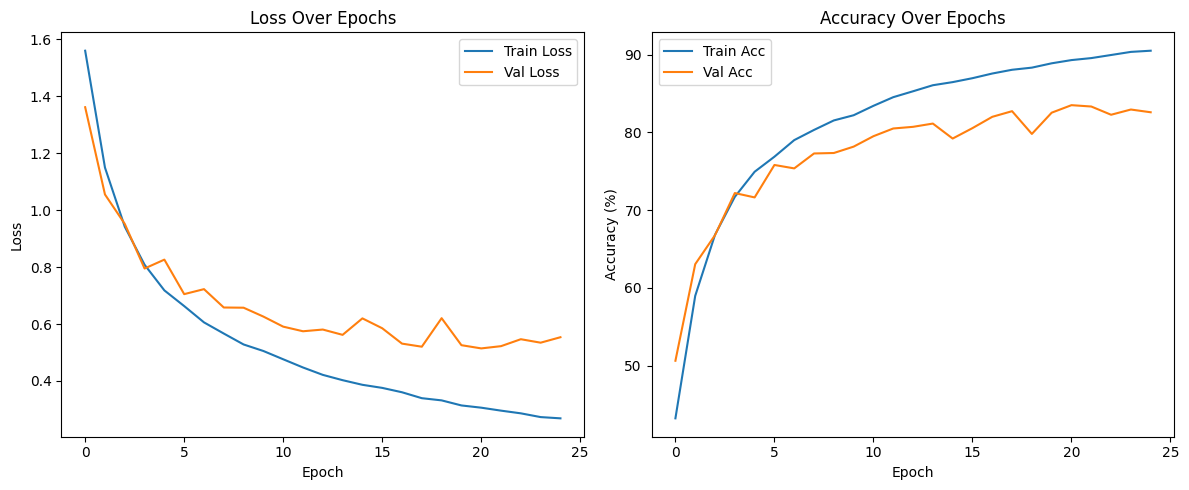

In [8]:
train_loss, train_acc = zip(*train_hist)
val_loss, val_acc = zip(*val_hist)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
